Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=e9708d44521b2284854102a31b56b536cc6fea6fd613801a879a73a4476e5a4f
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 16.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 18.7 MB/s 
     |████████████████████████████████| 163 kB 40.4 MB/s 
     |████████████████████████████████| 7.6 MB 36.7 MB/s 
[2513, 4923, 516]
[29, 29, 29]
[2513, 4923, 4974]
[29, 29,

In [ ]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-24 05:31:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-24 05:31:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-24 05:31:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [ ]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [ ]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [ ]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [ ]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3586 words (3149 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          673600    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 844,892
Trainable params: 844,892
Non-trainable param

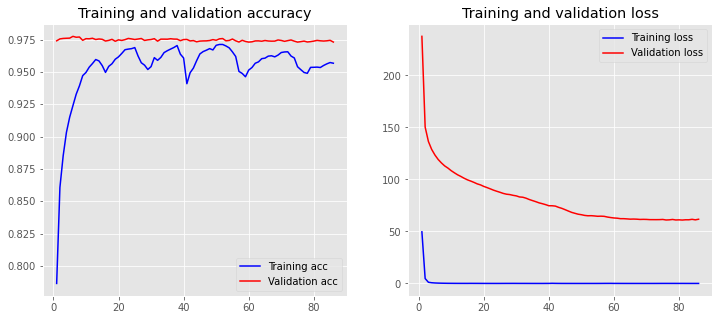

6/6 [==============================] - 3s 84ms/step
F1-score: 72.7%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8888888888888888,0.8979591836734694,0.8934010152284263,98.0
Apparatus-Descriptor,0.4,0.6666666666666666,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.3076923076923077,0.380952380952381,13.0
Brand,0.4074074074074074,0.4074074074074074,0.4074074074074074,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5862068965517241,0.85,0.6938775510204082,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9247311827956989,0.9885057471264368,0.9555555555555556,87.0
Material,0.6459459459459459,0.7563291139240507,0.696793002915452,316.0
Material-Descriptor,0.53125,0.5730337078651685,0.5513513513513514,89.0
Meta,0.2631578947368421,0.38461538461538464,0.3125,13.0
Nonrecipe-Material,0.23809523809523808,0.2,0.21739130434782608,25.0
Number,0.9248

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3570 words (3143 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          671400    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 842,692
Trainable params: 842,692
Non-trainable par

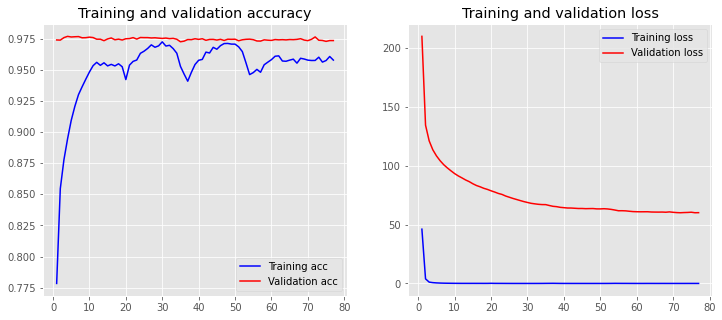

6/6 [==============================] - 3s 84ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4444444444444444,0.5714285714285714,0.5,7.0
Amount-Unit,0.9072164948453608,0.8979591836734694,0.9025641025641026,98.0
Apparatus-Descriptor,0.5384615384615384,0.7777777777777778,0.6363636363636364,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.5185185185185185,0.5185185185185185,0.5185185185185185,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6558265582655827,0.7658227848101266,0.7065693430656934,316.0
Material-Descriptor,0.4915254237288136,0.651685393258427,0.5603864734299517,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Materi

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3571 words (3148 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          672000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 843,292
Trainable params: 843,292
Non-trainable par

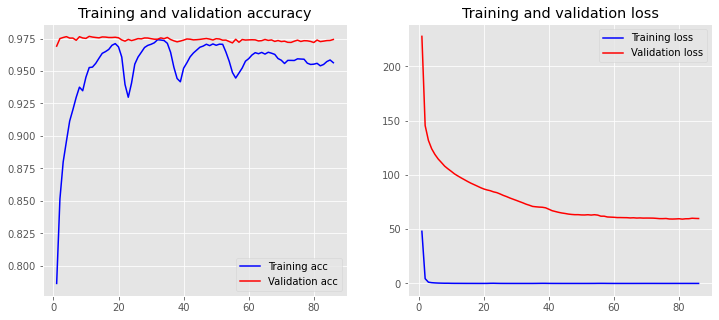

6/6 [==============================] - 3s 83ms/step
F1-score: 73.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.9183673469387755,0.9183673469387755,0.9183673469387755,98.0
Apparatus-Descriptor,0.3333333333333333,0.5555555555555556,0.4166666666666667,9.0
Apparatus-Property-Type,0.2,0.16666666666666666,0.1818181818181818,6.0
Apparatus-Unit,0.5714285714285714,0.3076923076923077,0.4,13.0
Brand,0.46875,0.5555555555555556,0.5084745762711864,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9659090909090909,0.9770114942528736,0.9714285714285714,87.0
Material,0.6732394366197183,0.7563291139240507,0.7123695976154993,316.0
Material-Descriptor,0.5217391304347826,0.5393258426966292,0.5303867403314917,89.0
Meta,0.2222222222222222,0.3076923076923077,0.2580645161290323,13.0
Nonrecipe-Material,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3570 words (3146 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          671700    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 842,992
Trainable params: 842,992
Non-trainable par

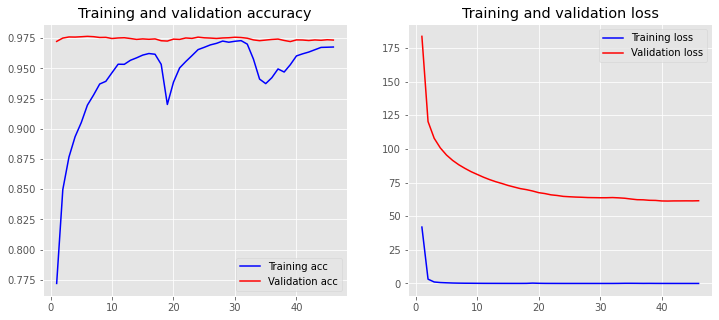

6/6 [==============================] - 3s 80ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.21428571428571427,0.42857142857142855,0.2857142857142857,7.0
Amount-Unit,0.8557692307692307,0.9081632653061225,0.8811881188118811,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.21428571428571427,0.2222222222222222,0.21818181818181817,27.0
Characterization-Apparatus,0.5,0.18181818181818182,0.26666666666666666,11.0
Condition-Misc,0.5,0.9,0.6428571428571429,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6086956521739131,0.7531645569620253,0.6732673267326733,316.0
Material-Descriptor,0.4563106796116505,0.5280898876404494,0.4895833333333333,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Materia

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3556 words (3150 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          670700    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 841,992
Trainable params: 841,992
Non-trainable par

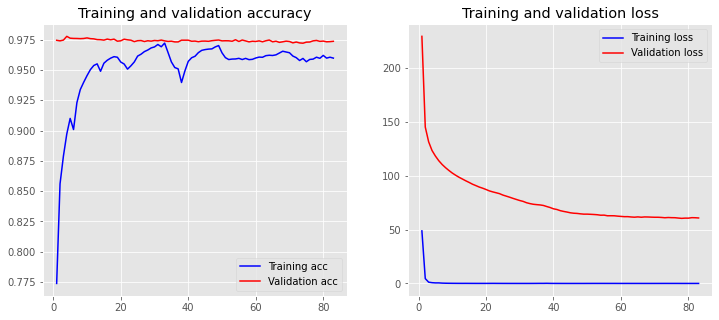

6/6 [==============================] - 4s 78ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3125,0.7142857142857143,0.43478260869565216,7.0
Amount-Unit,0.8737864077669902,0.9183673469387755,0.8955223880597014,98.0
Apparatus-Descriptor,0.5833333333333334,0.7777777777777778,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.46153846153846156,0.5714285714285714,13.0
Brand,0.631578947368421,0.4444444444444444,0.5217391304347826,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5588235294117647,0.95,0.7037037037037037,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6167076167076168,0.7943037974683544,0.6943291839557401,316.0
Material-Descriptor,0.4528301886792453,0.5393258426966292,0.4923076923076923,89.0
Meta,0.23076923076923078,0.23076923076923078,0.23076923076923078,13.0
Nonrecipe-Mate

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3552 words (3150 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          670300    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 841,592
Trainable params: 841,592
Non-trainable par

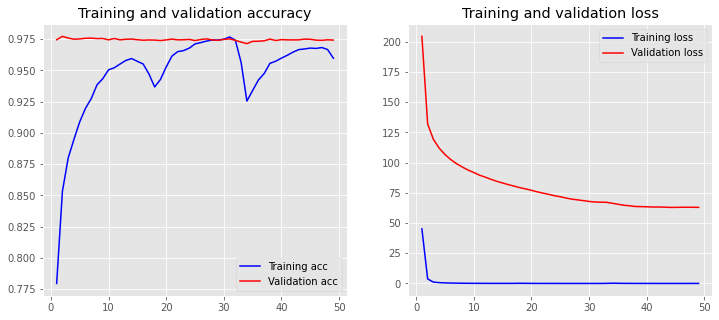

6/6 [==============================] - 3s 96ms/step
F1-score: 74.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.38461538461538464,0.7142857142857143,0.5,7.0
Amount-Unit,0.875,0.9285714285714286,0.900990099009901,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.45454545454545453,0.37037037037037035,0.40816326530612246,27.0
Characterization-Apparatus,0.3333333333333333,0.18181818181818182,0.23529411764705885,11.0
Condition-Misc,0.5161290322580645,0.8,0.6274509803921569,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6730769230769231,0.7753164556962026,0.7205882352941179,316.0
Material-Descriptor,0.53,0.5955056179775281,0.5608465608465608,89.0
Meta,0.26666666666666666,0.3076923076923077,0.28571428571428575,13.0
Nonrecipe-Material,0.34615384

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3558 words (3142 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          670100    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 841,392
Trainable params: 841,392
Non-trainable par

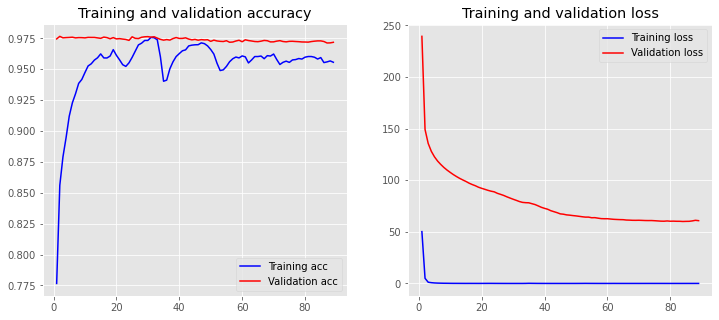

6/6 [==============================] - 3s 89ms/step
F1-score: 73.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.45454545454545453,0.7142857142857143,0.5555555555555556,7.0
Amount-Unit,0.9117647058823529,0.9489795918367347,0.9300000000000002,98.0
Apparatus-Descriptor,0.4444444444444444,0.4444444444444444,0.4444444444444444,9.0
Apparatus-Property-Type,0.3333333333333333,0.3333333333333333,0.3333333333333333,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.631578947368421,0.4444444444444444,0.5217391304347826,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9659090909090909,0.9770114942528736,0.9714285714285714,87.0
Material,0.6545454545454545,0.7974683544303798,0.7189728958630528,316.0
Material-Descriptor,0.48717948717948717,0.6404494382022472,0.553398058252427

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3566 words (3149 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          671600    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 842,892
Trainable params: 842,892
Non-trainable par

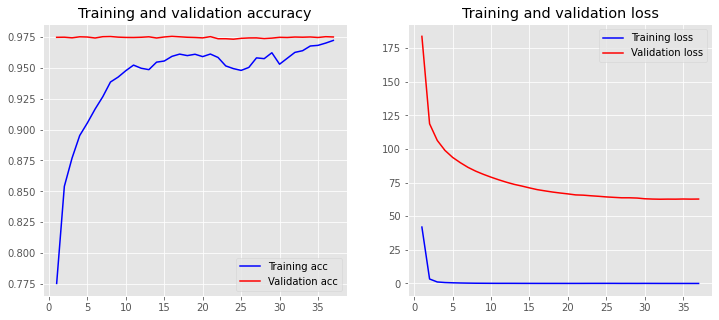

6/6 [==============================] - 3s 88ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.91,0.9285714285714286,0.9191919191919193,98.0
Apparatus-Descriptor,0.5,0.7777777777777778,0.6086956521739131,9.0
Apparatus-Property-Type,0.4,0.3333333333333333,0.3636363636363636,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.5,0.48148148148148145,0.49056603773584906,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.5428571428571428,0.95,0.6909090909090908,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6481481481481481,0.7753164556962026,0.7060518731988473,316.0
Material-Descriptor,0.48623853211009177,0.5955056179775281,0.5353535353535354,89.0
Meta,0.21428571428571427,0.23076923076923078,0.222

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3564 words (3145 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 158, 100)          671000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 842,292
Trainable params: 842,292
Non-trainable par

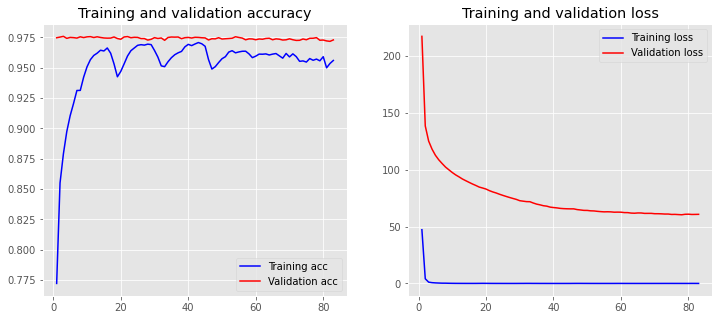

6/6 [==============================] - 3s 89ms/step
F1-score: 74.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.5714285714285714,0.38095238095238093,7.0
Amount-Unit,0.9191919191919192,0.9285714285714286,0.9238578680203046,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.15384615384615385,0.23529411764705882,13.0
Brand,0.6,0.5555555555555556,0.576923076923077,27.0
Characterization-Apparatus,0.4,0.18181818181818182,0.25000000000000006,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9148936170212766,0.9885057471264368,0.9502762430939227,87.0
Material,0.6902887139107612,0.8322784810126582,0.7546628407460545,316.0
Material-Descriptor,0.4824561403508772,0.6179775280898876,0.541871921182266,89.0
Meta,0.38461538461538464,0.38461538461538464,0.38461538461538464,13

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2817
Points in y_train after augmentation: 2817
Converted 3559 words (3146 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 158, 100)          670600    
                                                                 
 bidirectional_9 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 841,892
Trainable params: 841,892
Non-trainable par

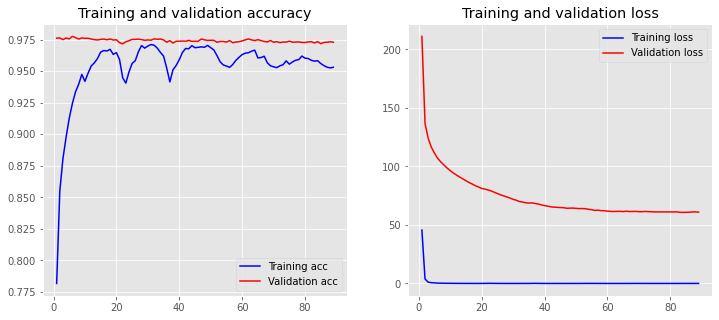

6/6 [==============================] - 4s 95ms/step
F1-score: 74.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.26666666666666666,0.5714285714285714,0.36363636363636365,7.0
Amount-Unit,0.9108910891089109,0.9387755102040817,0.9246231155778896,98.0
Apparatus-Descriptor,0.5384615384615384,0.7777777777777778,0.6363636363636364,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.625,0.38461538461538464,0.4761904761904762,13.0
Brand,0.6296296296296297,0.6296296296296297,0.6296296296296297,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5454545454545454,0.9,0.679245283018868,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6766304347826086,0.7879746835443038,0.7280701754385964,316.0
Material-Descriptor,0.5192307692307693,0.6067415730337079,0.5595854922279794,89.0
Meta,0.23529411764705882,0.3076923076923077,0.2666666666

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3637 words (3172 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 158, 100)          681000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,292
Trainable params: 852,292
Non-trainable pa

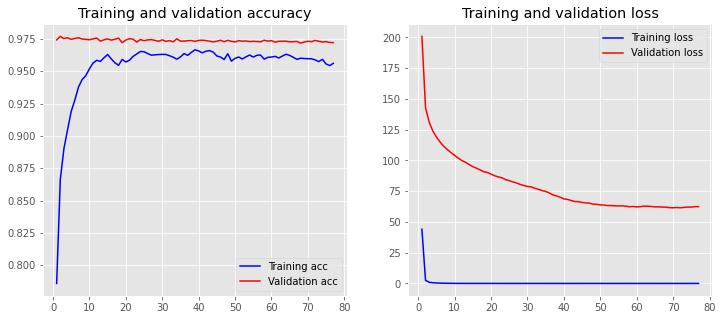

6/6 [==============================] - 3s 81ms/step
F1-score: 73.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.9117647058823529,0.9489795918367347,0.9300000000000002,98.0
Apparatus-Descriptor,0.3333333333333333,0.6666666666666666,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.46153846153846156,0.48000000000000004,13.0
Brand,0.5833333333333334,0.5185185185185185,0.5490196078431373,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.37777777777777777,0.85,0.523076923076923,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6956521739130435,0.759493670886076,0.7261724659606656,316.0
Material-Descriptor,0.5151515151515151,0.5730337078651685,0.5425531914893618,89.0
Meta,0.21052631578947367,0.3076923076923077,0.25,13.0
Nonrecipe-Material,0.3125,0.4,0.3508771929824561,25.0
Number,0.92

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3634 words (3172 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 158, 100)          680700    
                                                                 
 bidirectional_11 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 851,992
Trainable params: 851,992
Non-trainable pa

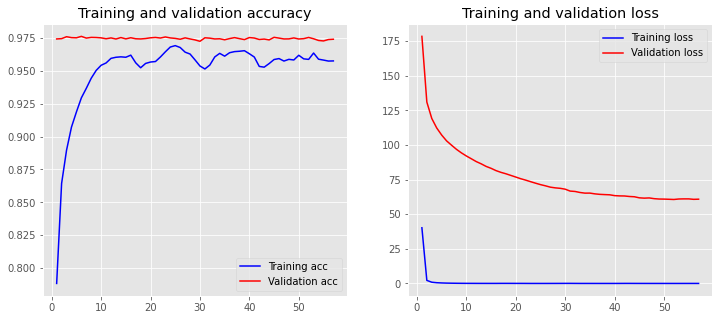

6/6 [==============================] - 3s 89ms/step
F1-score: 74.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.5714285714285714,0.38095238095238093,7.0
Amount-Unit,0.89,0.9081632653061225,0.8989898989898989,98.0
Apparatus-Descriptor,0.3333333333333333,0.6666666666666666,0.4444444444444444,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.875,0.5384615384615384,0.6666666666666667,13.0
Brand,0.5384615384615384,0.5185185185185185,0.5283018867924528,27.0
Characterization-Apparatus,0.25,0.18181818181818182,0.2105263157894737,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.7352941176470589,0.7911392405063291,0.7621951219512195,316.0
Material-Descriptor,0.5050505050505051,0.5617977528089888,0.5319148936170213,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3650 words (3168 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 158, 100)          681900    
                                                                 
 bidirectional_12 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 853,192
Trainable params: 853,192
Non-trainable pa

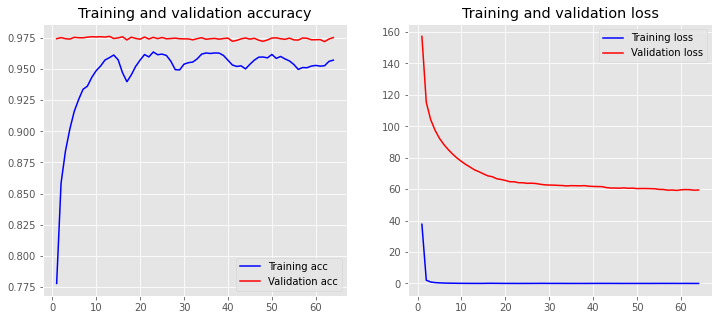

6/6 [==============================] - 3s 80ms/step
F1-score: 73.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.91,0.9285714285714286,0.9191919191919193,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.3333333333333333,0.16666666666666666,0.2222222222222222,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.391304347826087,0.3333333333333333,0.36,27.0
Characterization-Apparatus,0.3333333333333333,0.18181818181818182,0.23529411764705885,11.0
Condition-Misc,0.6428571428571429,0.9,0.75,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.8947368421052632,0.9770114942528736,0.9340659340659342,87.0
Material,0.68,0.7531645569620253,0.7147147147147146,316.0
Material-Descriptor,0.5,0.5617977528089888,0.5291005291005291,89.0
Meta,0.2857142857142857,0.3076923076923077,0.29629629629629634,13.0
Nonrecipe-Mate

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3658 words (3180 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 158, 100)          683900    
                                                                 
 bidirectional_13 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 855,192
Trainable params: 855,192
Non-trainable pa

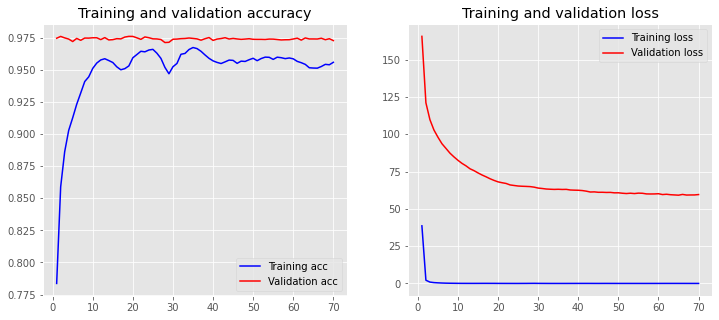

6/6 [==============================] - 4s 91ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4444444444444444,0.5714285714285714,0.5,7.0
Amount-Unit,0.8712871287128713,0.8979591836734694,0.8844221105527638,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.3076923076923077,0.47058823529411764,13.0
Brand,0.631578947368421,0.4444444444444444,0.5217391304347826,27.0
Characterization-Apparatus,0.3333333333333333,0.18181818181818182,0.23529411764705885,11.0
Condition-Misc,0.5769230769230769,0.75,0.6521739130434783,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6378378378378379,0.7468354430379747,0.6880466472303207,316.0
Material-Descriptor,0.4774774774774775,0.5955056179775281,0.53,89.0
Meta,0.4166666666666667,0.38461538461538464,0.4,13.0
Nonrecipe-Material,0.41379310344827586,0.48,0.444

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3643 words (3168 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 158, 100)          681200    
                                                                 
 bidirectional_14 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,492
Trainable params: 852,492
Non-trainable pa

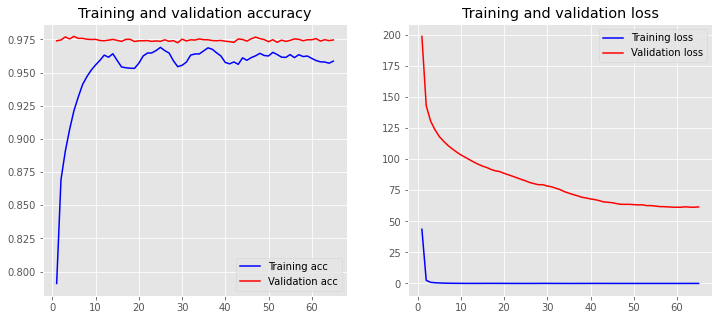

6/6 [==============================] - 4s 93ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.92,0.9387755102040817,0.9292929292929293,98.0
Apparatus-Descriptor,0.35714285714285715,0.5555555555555556,0.43478260869565216,9.0
Apparatus-Property-Type,0.16666666666666666,0.16666666666666666,0.16666666666666666,6.0
Apparatus-Unit,0.625,0.38461538461538464,0.4761904761904762,13.0
Brand,0.5454545454545454,0.4444444444444444,0.4897959183673469,27.0
Characterization-Apparatus,0.2857142857142857,0.18181818181818182,0.2222222222222222,11.0
Condition-Misc,0.6538461538461539,0.85,0.7391304347826088,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6569148936170213,0.7816455696202531,0.7138728323699423,316.0
Material-Descriptor,0.5047619047619047,0.5955056179775281,0.5463917525

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3662 words (3180 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 158, 100)          684300    
                                                                 
 bidirectional_15 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 855,592
Trainable params: 855,592
Non-trainable pa

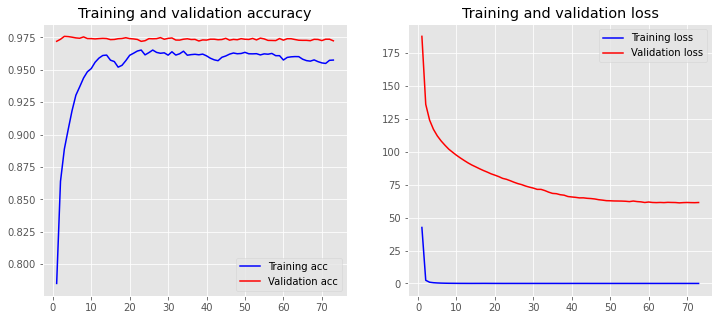

6/6 [==============================] - 4s 85ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.42857142857142855,0.3157894736842105,7.0
Amount-Unit,0.8725490196078431,0.9081632653061225,0.89,98.0
Apparatus-Descriptor,0.42857142857142855,0.6666666666666666,0.5217391304347826,9.0
Apparatus-Property-Type,0.16666666666666666,0.16666666666666666,0.16666666666666666,6.0
Apparatus-Unit,0.8571428571428571,0.46153846153846156,0.6,13.0
Brand,0.4666666666666667,0.5185185185185185,0.4912280701754386,27.0
Characterization-Apparatus,0.08333333333333333,0.09090909090909091,0.08695652173913043,11.0
Condition-Misc,0.5277777777777778,0.95,0.6785714285714285,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9431818181818182,0.9540229885057471,0.9485714285714286,87.0
Material,0.6452513966480447,0.7310126582278481,0.685459940652819,316.0
Material-Descriptor,0.49056603773584906,0.5842696629213483,0.5333333333333333,89.0
Met

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3638 words (3178 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 158, 100)          681700    
                                                                 
 bidirectional_16 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 852,992
Trainable params: 852,992
Non-trainable pa

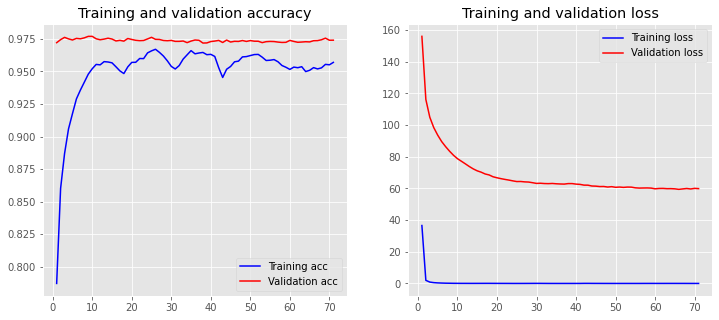

6/6 [==============================] - 4s 103ms/step
F1-score: 72.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.898989898989899,0.9081632653061225,0.9035532994923858,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.6470588235294118,0.4074074074074074,0.5,27.0
Characterization-Apparatus,0.5,0.18181818181818182,0.26666666666666666,11.0
Condition-Misc,0.6296296296296297,0.85,0.723404255319149,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6430517711171662,0.7468354430379747,0.6910688140556369,316.0
Material-Descriptor,0.6025641025641025,0.5280898876404494,0.562874251497006,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.2692307692307692,0.28,0.27450980392156865,25.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3652 words (3172 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 158, 100)          682500    
                                                                 
 bidirectional_17 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 853,792
Trainable params: 853,792
Non-trainable pa

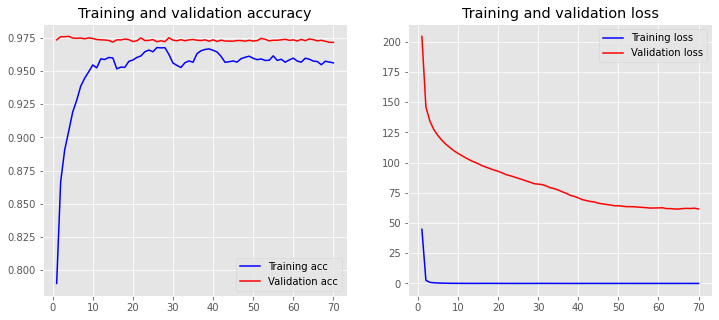

6/6 [==============================] - 3s 88ms/step
F1-score: 73.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8686868686868687,0.8775510204081632,0.8730964467005075,98.0
Apparatus-Descriptor,0.5,0.5555555555555556,0.5263157894736842,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.65,0.48148148148148145,0.553191489361702,27.0
Characterization-Apparatus,0.6666666666666666,0.18181818181818182,0.28571428571428575,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6694214876033058,0.7689873417721519,0.7157584683357879,316.0
Material-Descriptor,0.4954954954954955,0.6179775280898876,0.55,89.0
Meta,0.3125,0.38461538461538464,0.3448275862068966,13.0
Nonrecipe-Material,0.3448275862068966,0.4,0.

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3628 words (3167 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 158, 100)          679600    
                                                                 
 bidirectional_18 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 850,892
Trainable params: 850,892
Non-trainable pa

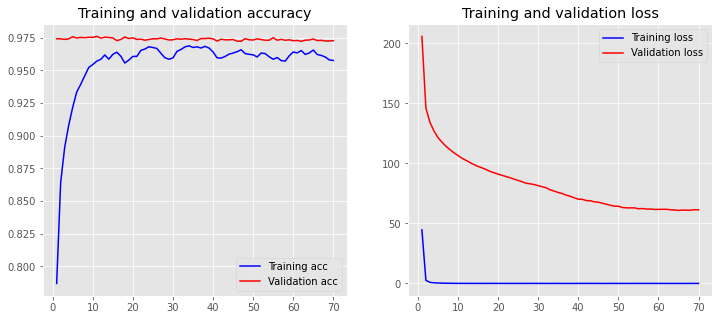

6/6 [==============================] - 3s 82ms/step
F1-score: 72.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4444444444444444,0.5714285714285714,0.5,7.0
Amount-Unit,0.8787878787878788,0.8877551020408163,0.8832487309644671,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.625,0.38461538461538464,0.4761904761904762,13.0
Brand,0.5909090909090909,0.48148148148148145,0.5306122448979591,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5862068965517241,0.85,0.6938775510204082,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9545454545454546,0.9655172413793104,0.96,87.0
Material,0.6722689075630253,0.759493670886076,0.7132243684992571,316.0
Material-Descriptor,0.44339622641509435,0.5280898876404494,0.48205128205128206,89.0
Meta,0.29411764705882354,0.38461538461538464,0.33333333333333337,13.0
Nonrecipe-Material,0.2413793103448276,0.28,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Converted 3655 words (3171 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 158, 100)          682700    
                                                                 
 bidirectional_19 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 853,992
Trainable params: 853,992
Non-trainable pa

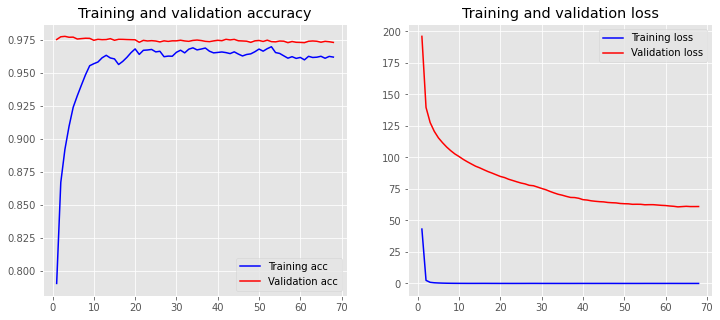

6/6 [==============================] - 4s 87ms/step
F1-score: 73.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.5714285714285714,0.34782608695652173,7.0
Amount-Unit,0.8942307692307693,0.9489795918367347,0.9207920792079209,98.0
Apparatus-Descriptor,0.5714285714285714,0.8888888888888888,0.6956521739130435,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.3333333333333333,0.07692307692307693,0.125,13.0
Brand,0.42857142857142855,0.5555555555555556,0.48387096774193544,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.53125,0.85,0.6538461538461537,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6621983914209115,0.7816455696202531,0.7169811320754716,316.0
Material-Descriptor,0.6296296296296297,0.5730337078651685,0.6,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3682 words (3198 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 158, 100)          688100    
                                                                 
 bidirectional_20 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 859,392
Trainable params: 859,392
Non-trainable pa

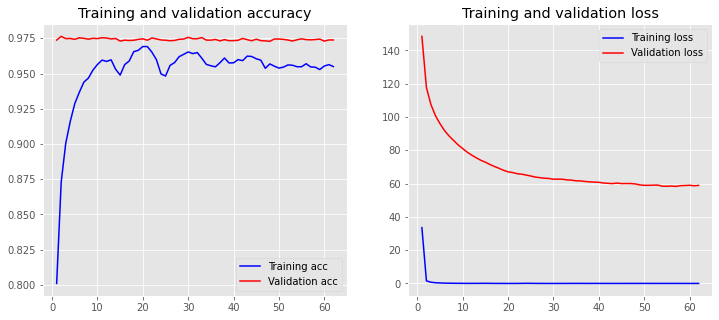

6/6 [==============================] - 4s 91ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8811881188118812,0.9081632653061225,0.8944723618090452,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5555555555555556,0.38461538461538464,0.4545454545454546,13.0
Brand,0.44,0.4074074074074074,0.4230769230769231,27.0
Characterization-Apparatus,0.1,0.09090909090909091,0.09523809523809525,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.06666666666666667,1.0,0.125,1.0
Condition-Unit,0.9247311827956989,0.9885057471264368,0.9555555555555556,87.0
Material,0.6407506702412868,0.7563291139240507,0.6937590711175616,316.0
Material-Descriptor,0.43859649122807015,0.5617977528089888,0.49261083743842365,89.0
Meta,0.2,0.23076923076923078,0.21428571428571427,13.0
Nonrecipe-Material,0.26470

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3732 words (3193 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 158, 100)          692600    
                                                                 
 bidirectional_21 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 863,892
Trainable params: 863,892
Non-trainable pa

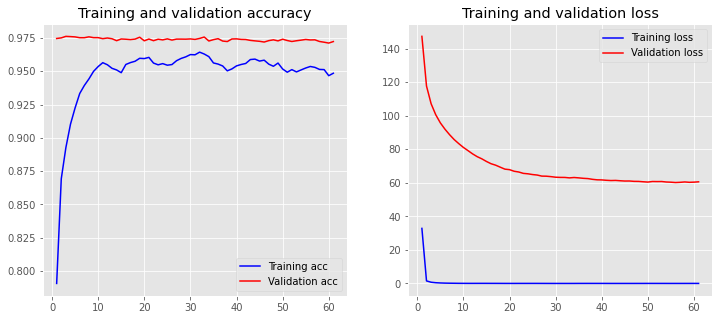

6/6 [==============================] - 4s 90ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.898989898989899,0.9081632653061225,0.9035532994923858,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.625,0.38461538461538464,0.4761904761904762,13.0
Brand,0.45454545454545453,0.5555555555555556,0.5,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5,0.8,0.6153846153846154,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6816901408450704,0.7658227848101266,0.7213114754098359,316.0
Material-Descriptor,0.5208333333333334,0.5617977528089888,0.5405405405405405,89.0
Meta,0.22727272727272727,0.38461538461538464,0.2857142857142857,13.0
Nonrecipe-Material,0.3333333333333333,0.28,0.3043

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3716 words (3209 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 158, 100)          692600    
                                                                 
 bidirectional_22 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 863,892
Trainable params: 863,892
Non-trainable pa

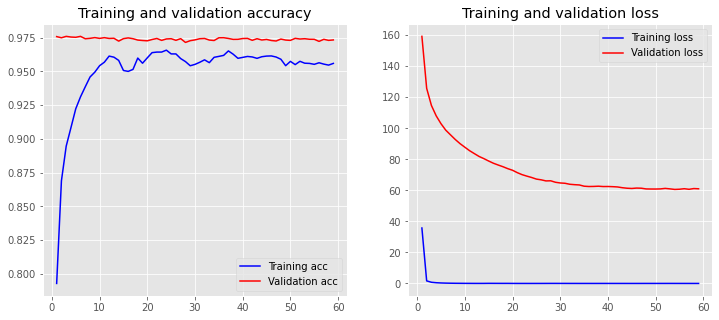

6/6 [==============================] - 4s 86ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.8571428571428571,0.5454545454545455,7.0
Amount-Unit,0.8811881188118812,0.9081632653061225,0.8944723618090452,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.3333333333333333,0.16666666666666666,0.2222222222222222,6.0
Apparatus-Unit,0.8571428571428571,0.46153846153846156,0.6,13.0
Brand,0.4827586206896552,0.5185185185185185,0.5,27.0
Characterization-Apparatus,0.14285714285714285,0.09090909090909091,0.1111111111111111,11.0
Condition-Misc,0.45454545454545453,0.75,0.5660377358490566,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9550561797752809,0.9770114942528736,0.9659090909090908,87.0
Material,0.6941896024464832,0.7183544303797469,0.7060653188180405,316.0
Material-Descriptor,0.4857142857142857,0.5730337078651685,0.5257731958762887,89.0
Meta,0.1,0.07692307692307693,0.0869565

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3714 words (3195 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 158, 100)          691000    
                                                                 
 bidirectional_23 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 862,292
Trainable params: 862,292
Non-trainable pa

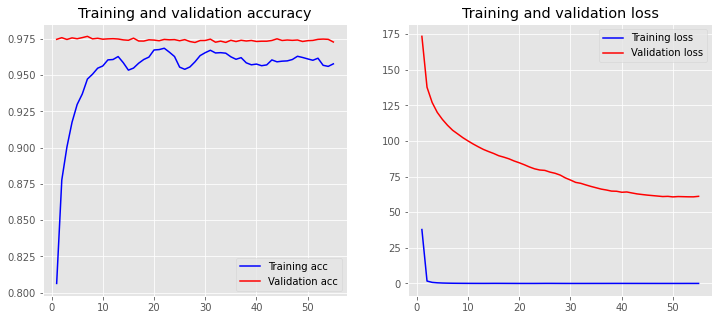

6/6 [==============================] - 4s 88ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.5714285714285714,0.38095238095238093,7.0
Amount-Unit,0.9375,0.9183673469387755,0.9278350515463918,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5714285714285714,0.3076923076923077,0.4,13.0
Brand,0.42857142857142855,0.4444444444444444,0.43636363636363634,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6744186046511628,0.7341772151898734,0.703030303030303,316.0
Material-Descriptor,0.5,0.5955056179775281,0.5435897435897437,89.0
Meta,0.3333333333333333,0.23076923076923078,0.27272727272727276,13.0
Nonrecipe-Material,0.20833333333333334,0.4,0.2

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3709 words (3192 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 158, 100)          690200    
                                                                 
 bidirectional_24 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 861,492
Trainable params: 861,492
Non-trainable pa

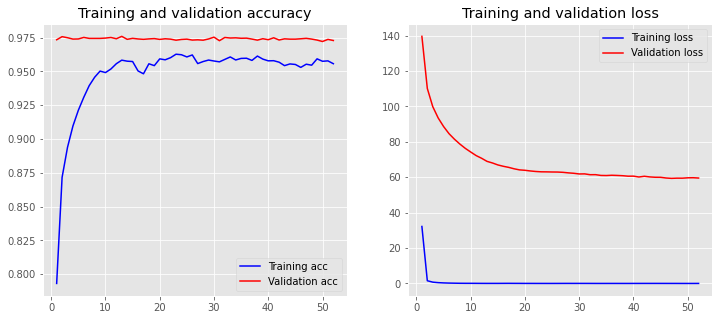

6/6 [==============================] - 4s 84ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5714285714285714,0.5714285714285714,0.5714285714285714,7.0
Amount-Unit,0.9029126213592233,0.9489795918367347,0.9253731343283583,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.42105263157894735,0.2962962962962963,0.34782608695652173,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.5,0.85,0.6296296296296295,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6638418079096046,0.7436708860759493,0.7014925373134328,316.0
Material-Descriptor,0.5,0.4606741573033708,0.4795321637426901,89.0
Meta,0.23529411764705882,0.3076923076923077,0.26666666666666666,13.0


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3714 words (3195 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          691000    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 862,292
Trainable params: 862,292
Non-trainable param

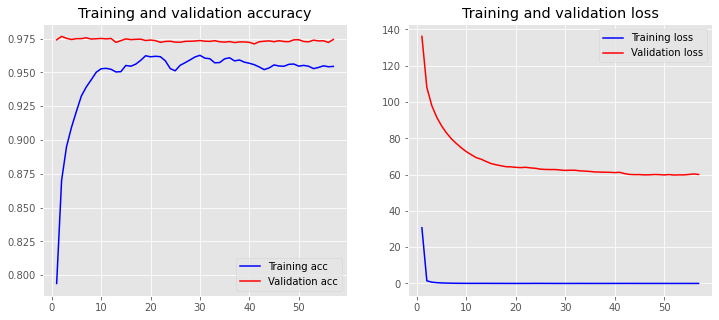

6/6 [==============================] - 4s 87ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.92,0.9387755102040817,0.9292929292929293,98.0
Apparatus-Descriptor,0.46153846153846156,0.6666666666666666,0.5454545454545455,9.0
Apparatus-Property-Type,0.5,0.16666666666666666,0.25,6.0
Apparatus-Unit,0.6666666666666666,0.46153846153846156,0.5454545454545455,13.0
Brand,0.631578947368421,0.4444444444444444,0.5217391304347826,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6129032258064516,0.95,0.7450980392156863,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9239130434782609,0.9770114942528736,0.9497206703910613,87.0
Material,0.6372795969773299,0.8006329113924051,0.7096774193548386,316.0
Material-Descriptor,0.48148148148148145,0.5842696629213483,0.5279187817258884,89.0
Meta,0.18181818181818182,0.15384615384615385,0.16666666666666669,13.0
Nonrecipe-Materi

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3719 words (3184 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          690400    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 861,692
Trainable params: 861,692
Non-trainable par

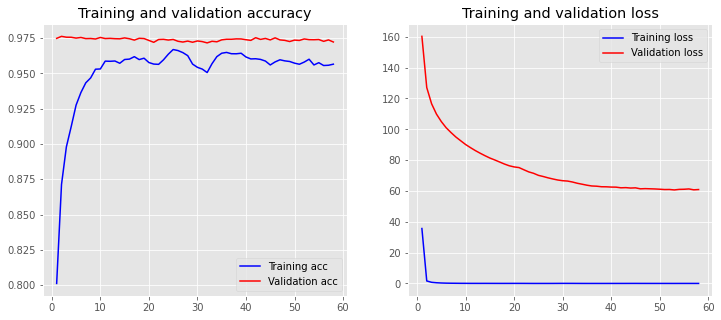

6/6 [==============================] - 4s 80ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.42857142857142855,0.375,7.0
Amount-Unit,0.8787878787878788,0.8877551020408163,0.8832487309644671,98.0
Apparatus-Descriptor,0.5,0.7777777777777778,0.6086956521739131,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.5294117647058824,0.3333333333333333,0.409090909090909,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6533333333333333,0.7753164556962026,0.7091172214182344,316.0
Material-Descriptor,0.5151515151515151,0.5730337078651685,0.5425531914893618,89.0
Meta,0.4444444444444444,0.3076923076923077,0.3636363636363637,13.0
Nonr

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3701 words (3200 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          690200    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 861,492
Trainable params: 861,492
Non-trainable par

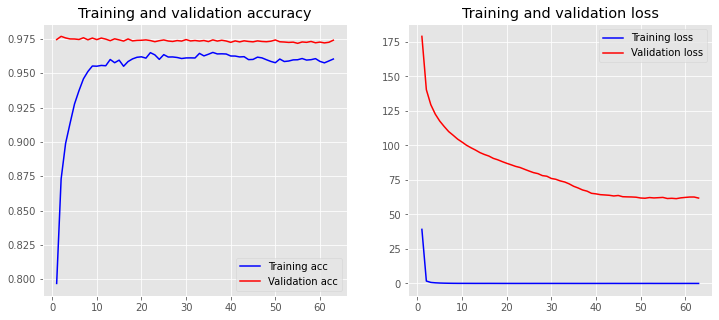

6/6 [==============================] - 4s 82ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.17647058823529413,0.42857142857142855,0.25,7.0
Amount-Unit,0.89,0.9081632653061225,0.8989898989898989,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.3333333333333333,0.25925925925925924,0.2916666666666667,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.6333333333333333,0.95,0.7599999999999999,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.662125340599455,0.7689873417721519,0.711566617862372,316.0
Material-Descriptor,0.46296296296296297,0.5617977528089888,0.5076142131979695,89.0
Meta,0.23809523809523808,0.38461538461538464,0.2941176470588235,13.0
Nonrecipe-Material,0.2,0.2,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3734 words (3193 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          692800    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 864,092
Trainable params: 864,092
Non-trainable par

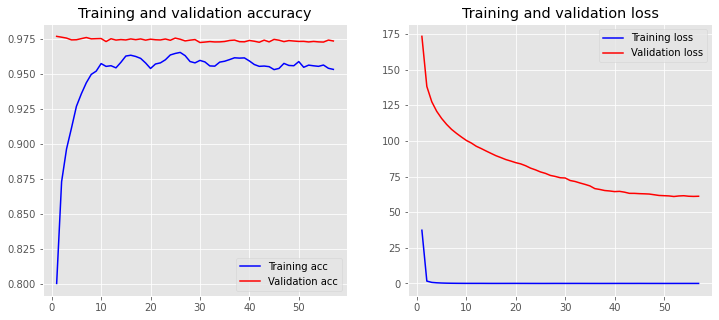

6/6 [==============================] - 3s 83ms/step
F1-score: 73.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2857142857142857,0.5714285714285714,0.38095238095238093,7.0
Amount-Unit,0.9090909090909091,0.9183673469387755,0.9137055837563451,98.0
Apparatus-Descriptor,0.3333333333333333,0.5555555555555556,0.4166666666666667,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.5714285714285714,0.4444444444444444,0.5,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6762177650429799,0.7468354430379747,0.7097744360902255,316.0
Material-Descriptor,0.4745762711864407,0.6292134831460674,0.5410628019323671,89.0
Meta,0.35294117647058826,0.461538461538

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 3943
Points in y_train after augmentation: 3943
Converted 3700 words (3181 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          688200    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 859,492
Trainable params: 859,492
Non-trainable par

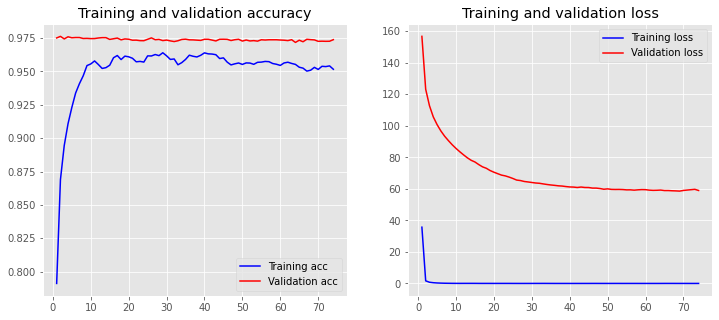

6/6 [==============================] - 4s 87ms/step
F1-score: 72.3%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.26666666666666666,0.5714285714285714,0.36363636363636365,7.0
Amount-Unit,0.9166666666666666,0.8979591836734694,0.9072164948453607,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.23076923076923078,0.3529411764705882,13.0
Brand,0.55,0.4074074074074074,0.46808510638297873,27.0
Characterization-Apparatus,0.2,0.18181818181818182,0.1904761904761905,11.0
Condition-Misc,0.6,0.9,0.7200000000000001,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.8936170212765957,0.9655172413793104,0.9281767955801106,87.0
Material,0.6786703601108033,0.7753164556962026,0.723781388478582,316.0
Material-Descriptor,0.4722222222222222,0.5730337078651685,0.5177664974619289,89.0
Meta,0.35714285714285715,0.38461538461538464,0.3703703703703704,13.0
Nonrecipe-Material,0.2857142857142857,0.32,0.30188679245283023,25.0
N

In [ ]:
number_of_training_models = 5
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3747 words (3202 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          695000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 866,292
Trainable params: 866,292
Non-trainable par

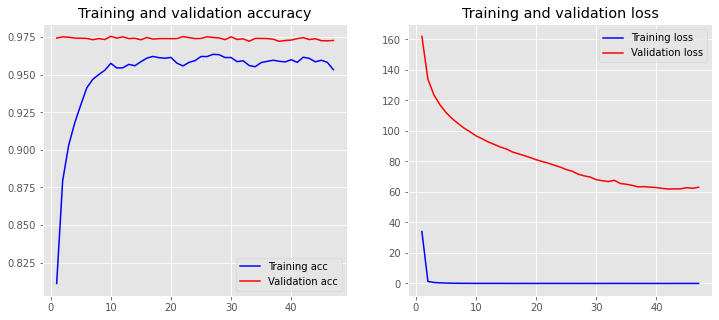

6/6 [==============================] - 4s 85ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.5714285714285714,0.5333333333333333,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.5714285714285714,0.8888888888888888,0.6956521739130435,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.47368421052631576,0.3333333333333333,0.391304347826087,27.0
Characterization-Apparatus,0.42857142857142855,0.2727272727272727,0.33333333333333326,11.0
Condition-Misc,0.5714285714285714,0.8,0.6666666666666666,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9347826086956522,0.9885057471264368,0.9608938547486033,87.0
Material,0.6571428571428571,0.7278481012658228,0.6906906906906907,316.0
Material-Descriptor,0.5274725274725275,0.5393258426966292,0.5333333333333333,89.0
Meta,0.38461538461538464,0.384615384615384

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3788 words (3224 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          701300    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 872,592
Trainable params: 872,592
Non-trainable par

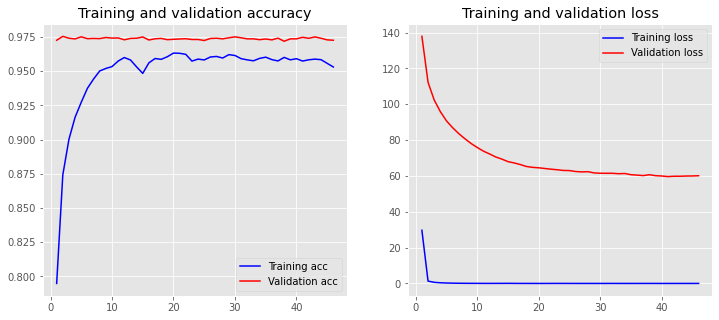

6/6 [==============================] - 4s 82ms/step
F1-score: 72.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.89,0.9081632653061225,0.8989898989898989,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.6521739130434783,0.5555555555555556,0.6,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5151515151515151,0.85,0.6415094339622641,20.0
Condition-Type,0.0625,1.0,0.11764705882352941,1.0
Condition-Unit,0.9550561797752809,0.9770114942528736,0.9659090909090908,87.0
Material,0.6370757180156658,0.7721518987341772,0.698140200286123,316.0
Material-Descriptor,0.5048543689320388,0.5842696629213483,0.5416666666666667,89.0
Meta,0.25,0.23076923076923078,0.24000000000000002,13.0
Nonrecipe-Material,0.36363636363636365,0.32,0.3404255319148936,25.0
Number,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3756 words (3216 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          697300    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 868,592
Trainable params: 868,592
Non-trainable par

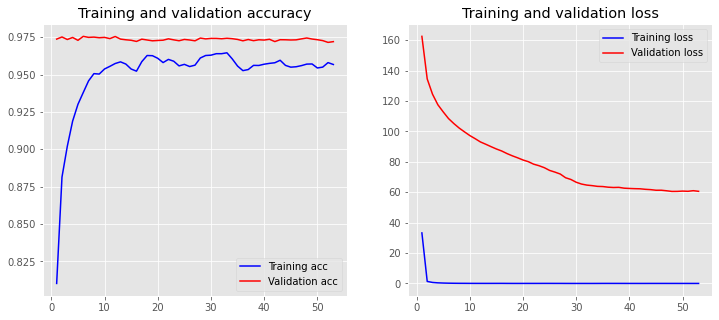

6/6 [==============================] - 4s 87ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4444444444444444,0.5714285714285714,0.5,7.0
Amount-Unit,0.88,0.8979591836734694,0.888888888888889,98.0
Apparatus-Descriptor,0.375,0.6666666666666666,0.4800000000000001,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.52,0.48148148148148145,0.5,27.0
Characterization-Apparatus,0.375,0.2727272727272727,0.3157894736842105,11.0
Condition-Misc,0.47058823529411764,0.8,0.5925925925925927,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6818181818181818,0.759493670886076,0.7185628742514971,316.0
Material-Descriptor,0.44660194174757284,0.5168539325842697,0.4791666666666667,89.0
Meta,0.17647058823529413,0.23076923076923078,0.20000000000000004,13.0
Nonrecipe-Material,0.2631578947368421,0.4,0.3

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3769 words (3210 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 158, 100)          698000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 869,292
Trainable params: 869,292
Non-trainable par

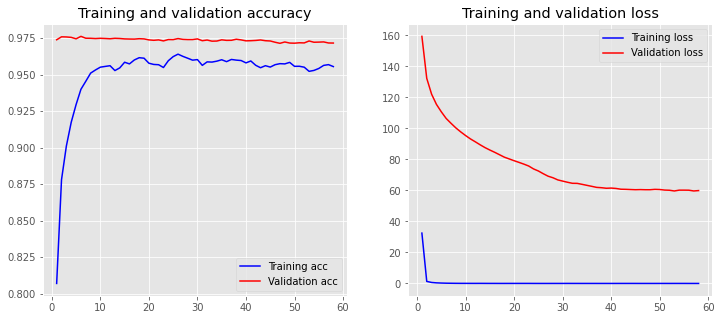

6/6 [==============================] - 3s 85ms/step
F1-score: 73.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8979591836734694,0.8979591836734694,0.8979591836734694,98.0
Apparatus-Descriptor,0.46153846153846156,0.6666666666666666,0.5454545454545455,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.65,0.48148148148148145,0.553191489361702,27.0
Characterization-Apparatus,0.3333333333333333,0.18181818181818182,0.23529411764705885,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6349614395886889,0.7816455696202531,0.7007092198581559,316.0
Material-Descriptor,0.5434782608695652,0.5617977528089888,0.5524861878453039,89.0
Meta,0.23076923076923078,0.23076923076923078,0.23076923

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3784 words (3194 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 158, 100)          697900    
                                                                 
 bidirectional_9 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 869,192
Trainable params: 869,192
Non-trainable par

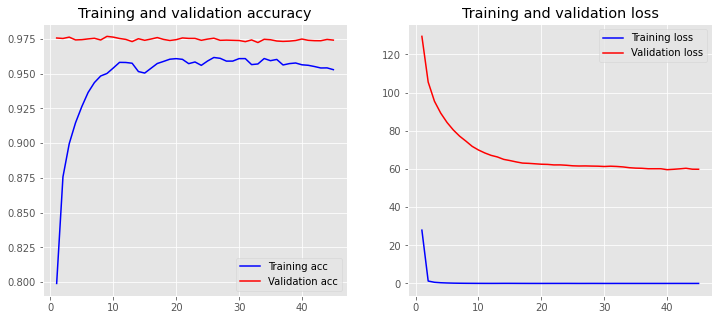

6/6 [==============================] - 3s 83ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.26666666666666666,0.5714285714285714,0.36363636363636365,7.0
Amount-Unit,0.9019607843137255,0.9387755102040817,0.92,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.3076923076923077,0.380952380952381,13.0
Brand,0.2857142857142857,0.37037037037037035,0.3225806451612903,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9010989010989011,0.9425287356321839,0.9213483146067416,87.0
Material,0.6763005780346821,0.740506329113924,0.7069486404833837,316.0
Material-Descriptor,0.5050505050505051,0.5617977528089888,0.5319148936170213,89.0
Meta,0.4444444444444444,0.3076923076923077,0.3636363636363637,13.0
Nonrecipe-Material,0.34615384615384615,0.36,0.35294117647058826,25

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3753 words (3201 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 158, 100)          695500    
                                                                 
 bidirectional_10 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 866,792
Trainable params: 866,792
Non-trainable pa

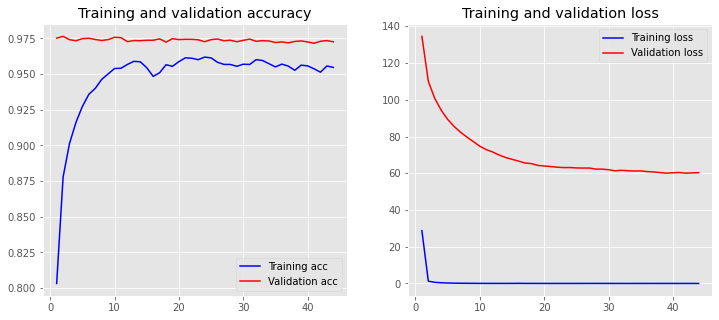

6/6 [==============================] - 3s 83ms/step
F1-score: 74.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8846153846153846,0.9387755102040817,0.9108910891089108,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.3870967741935484,0.4444444444444444,0.41379310344827586,27.0
Characterization-Apparatus,0.5,0.18181818181818182,0.26666666666666666,11.0
Condition-Misc,0.5294117647058824,0.9,0.6666666666666667,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9111111111111111,0.9425287356321839,0.9265536723163842,87.0
Material,0.7109144542772862,0.7626582278481012,0.7358778625954199,316.0
Material-Descriptor,0.5408163265306123,0.5955056179775281,0.5668449197860963,89.0
Meta,0.16666666666666666,0.23076923076923078,0.1935483870967742,13.0
Nonrecipe-Material

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3789 words (3211 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 158, 100)          700100    
                                                                 
 bidirectional_11 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 871,392
Trainable params: 871,392
Non-trainable pa

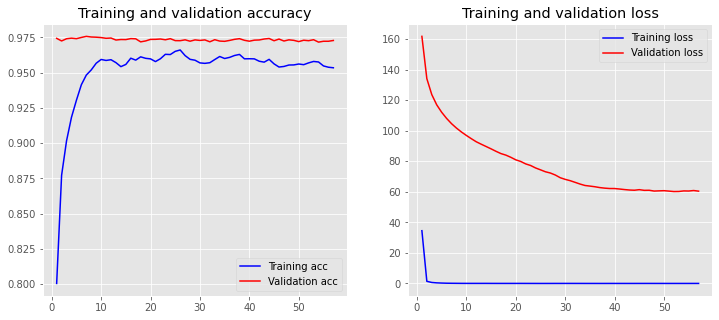

6/6 [==============================] - 4s 77ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.36363636363636365,0.5714285714285714,0.4444444444444444,7.0
Amount-Unit,0.8936170212765957,0.8571428571428571,0.875,98.0
Apparatus-Descriptor,0.26666666666666666,0.4444444444444444,0.33333333333333337,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.3076923076923077,0.380952380952381,13.0
Brand,0.46153846153846156,0.4444444444444444,0.4528301886792453,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.5277777777777778,0.95,0.6785714285714285,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9340659340659341,0.9770114942528736,0.9550561797752809,87.0
Material,0.6749311294765841,0.7753164556962026,0.7216494845360825,316.0
Material-Descriptor,0.575,0.5168539325842697,0.544378698224852,89.0
Meta,0.2777777777777778,0.38461538461538464,0.3225806451612903,13

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3755 words (3212 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 158, 100)          696800    
                                                                 
 bidirectional_12 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 868,092
Trainable params: 868,092
Non-trainable pa

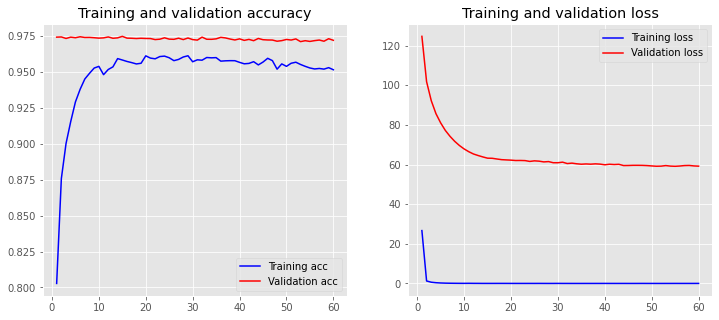

6/6 [==============================] - 4s 79ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8823529411764706,0.9183673469387755,0.9,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.631578947368421,0.4444444444444444,0.5217391304347826,27.0
Characterization-Apparatus,0.14285714285714285,0.09090909090909091,0.1111111111111111,11.0
Condition-Misc,0.5277777777777778,0.95,0.6785714285714285,20.0
Condition-Type,0.14285714285714285,1.0,0.25,1.0
Condition-Unit,0.9021739130434783,0.9540229885057471,0.9273743016759777,87.0
Material,0.6402116402116402,0.7658227848101266,0.6974063400576369,316.0
Material-Descriptor,0.5104166666666666,0.550561797752809,0.5297297297297298,89.0
Meta,0.14285714285714285,0.15384615384615385,0.14814814814814817,13.0
Nonrecipe-Material,

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3751 words (3208 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 158, 100)          696000    
                                                                 
 bidirectional_13 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 867,292
Trainable params: 867,292
Non-trainable pa

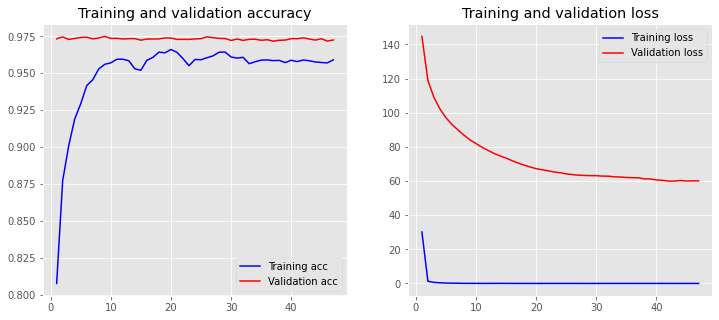

6/6 [==============================] - 4s 81ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.5714285714285714,0.32,7.0
Amount-Unit,0.9468085106382979,0.9081632653061225,0.9270833333333334,98.0
Apparatus-Descriptor,0.5833333333333334,0.7777777777777778,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.75,0.46153846153846156,0.5714285714285714,13.0
Brand,0.5384615384615384,0.5185185185185185,0.5283018867924528,27.0
Characterization-Apparatus,0.42857142857142855,0.2727272727272727,0.33333333333333326,11.0
Condition-Misc,0.45,0.9,0.6,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6449086161879896,0.7816455696202531,0.7067238912732475,316.0
Material-Descriptor,0.532608695652174,0.550561797752809,0.5414364640883977,89.0
Meta,0.23076923076923078,0.23076923076923078,0.23076923076923078,13.0
Nonrecipe-Materia

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4506
Points in y_train after augmentation: 4506
Converted 3760 words (3205 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 158, 100)          696600    
                                                                 
 bidirectional_14 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 867,892
Trainable params: 867,892
Non-trainable pa

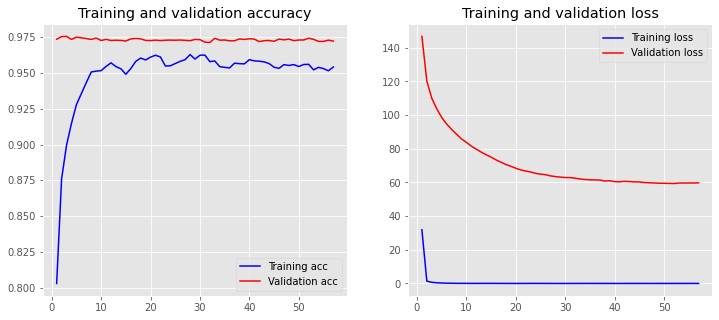

6/6 [==============================] - 3s 80ms/step
F1-score: 73.0%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.1111111111111111,0.14285714285714285,0.125,7.0
Amount-Unit,0.9270833333333334,0.9081632653061225,0.9175257731958762,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.625,0.38461538461538464,0.4761904761904762,13.0
Brand,0.6666666666666666,0.4444444444444444,0.5333333333333333,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5666666666666667,0.85,0.68,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9347826086956522,0.9885057471264368,0.9608938547486033,87.0
Material,0.6685393258426966,0.7531645569620253,0.7083333333333333,316.0
Material-Descriptor,0.4725274725274725,0.48314606741573035,0.47777777777777786,89.0
Meta,0.23076923076923078,0.23076923076923078,0.23076923076923078,13.0
Nonrecipe

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3977 words (3271 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 158, 100)          724900    
                                                                 
 bidirectional_15 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 896,192
Trainable params: 896,192
Non-trainable pa

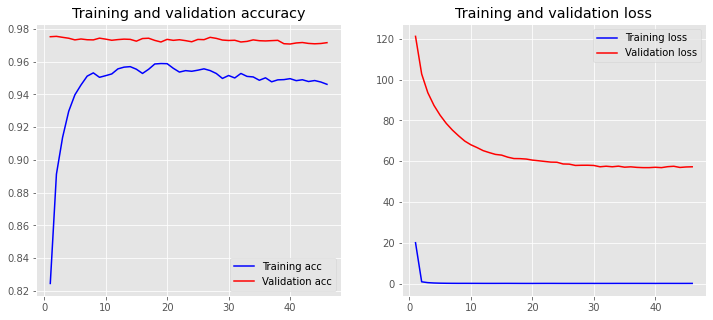

6/6 [==============================] - 4s 77ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.7142857142857143,0.588235294117647,7.0
Amount-Unit,0.8921568627450981,0.9285714285714286,0.9099999999999999,98.0
Apparatus-Descriptor,0.6,0.6666666666666666,0.631578947368421,9.0
Apparatus-Property-Type,0.16666666666666666,0.16666666666666666,0.16666666666666666,6.0
Apparatus-Unit,1.0,0.38461538461538464,0.5555555555555556,13.0
Brand,0.45,0.3333333333333333,0.3829787234042553,27.0
Characterization-Apparatus,0.2,0.09090909090909091,0.12500000000000003,11.0
Condition-Misc,0.6206896551724138,0.9,0.7346938775510204,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6676470588235294,0.7183544303797469,0.6920731707317073,316.0
Material-Descriptor,0.4528301886792453,0.5393258426966292,0.4923076923076923,89.0
Meta,0.38461538461538464,0.38461538461538464,0.38461538461538464,13.0
No

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3956 words (3265 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 158, 100)          722200    
                                                                 
 bidirectional_16 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 893,492
Trainable params: 893,492
Non-trainable pa

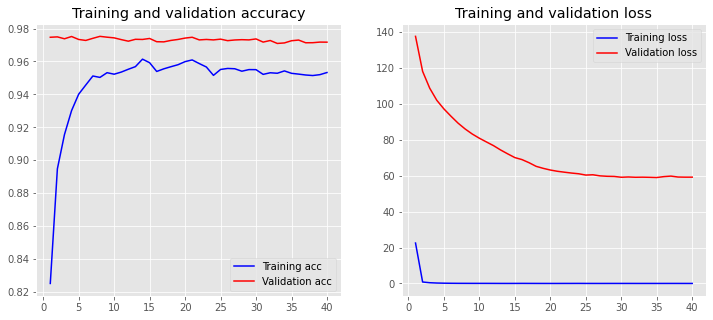

6/6 [==============================] - 3s 81ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2727272727272727,0.42857142857142855,0.33333333333333326,7.0
Amount-Unit,0.8910891089108911,0.9183673469387755,0.9045226130653267,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.23076923076923078,0.375,13.0
Brand,0.5263157894736842,0.37037037037037035,0.43478260869565216,27.0
Characterization-Apparatus,0.125,0.09090909090909091,0.10526315789473685,11.0
Condition-Misc,0.6333333333333333,0.95,0.7599999999999999,20.0
Condition-Type,0.1111111111111111,1.0,0.19999999999999998,1.0
Condition-Unit,0.9222222222222223,0.9540229885057471,0.9378531073446328,87.0
Material,0.6775147928994083,0.7246835443037974,0.7003058103975536,316.0
Material-Descriptor,0.47959183673469385,0.5280898876404494,0.5026737967914437,89.0
Meta,0.375,0.23076923076923078,0.285714285714285

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3968 words (3258 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 158, 100)          722700    
                                                                 
 bidirectional_17 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 893,992
Trainable params: 893,992
Non-trainable pa

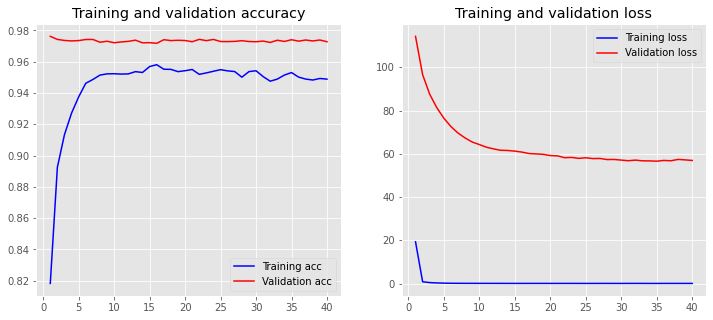

6/6 [==============================] - 4s 82ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.5714285714285714,0.5333333333333333,7.0
Amount-Unit,0.8947368421052632,0.8673469387755102,0.8808290155440415,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.25,0.16666666666666666,0.2,6.0
Apparatus-Unit,0.7777777777777778,0.5384615384615384,0.6363636363636364,13.0
Brand,0.38095238095238093,0.2962962962962963,0.3333333333333333,27.0
Characterization-Apparatus,0.16666666666666666,0.09090909090909091,0.11764705882352942,11.0
Condition-Misc,0.5757575757575758,0.95,0.7169811320754716,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6628895184135978,0.740506329113924,0.6995515695067266,316.0
Material-Descriptor,0.5466666666666666,0.4606741573033708,0.5,89.0
Meta,0.35294117647058826,0.46153846153846156,0.4000000000000001,13.0
No

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3957 words (3253 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 158, 100)          721100    
                                                                 
 bidirectional_18 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 892,392
Trainable params: 892,392
Non-trainable pa

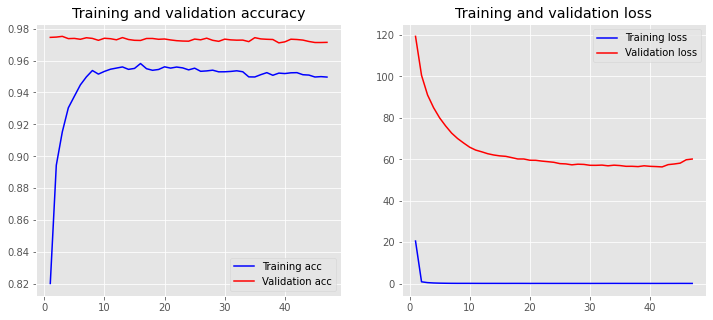

6/6 [==============================] - 4s 89ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.38461538461538464,0.7142857142857143,0.5,7.0
Amount-Unit,0.9375,0.9183673469387755,0.9278350515463918,98.0
Apparatus-Descriptor,0.35714285714285715,0.5555555555555556,0.43478260869565216,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6666666666666666,0.3076923076923077,0.42105263157894735,13.0
Brand,0.5333333333333333,0.2962962962962963,0.38095238095238093,27.0
Characterization-Apparatus,0.5,0.18181818181818182,0.26666666666666666,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9230769230769231,0.9655172413793104,0.9438202247191013,87.0
Material,0.6626506024096386,0.6962025316455697,0.6790123456790125,316.0
Material-Descriptor,0.4673913043478261,0.48314606741573035,0.47513812154696133,89.0
Meta,0.3,0.23076923076923078,0.2608695652173913,13.0
Nonrecipe-Material,0.30

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3960 words (3268 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 158, 100)          722900    
                                                                 
 bidirectional_19 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 894,192
Trainable params: 894,192
Non-trainable pa

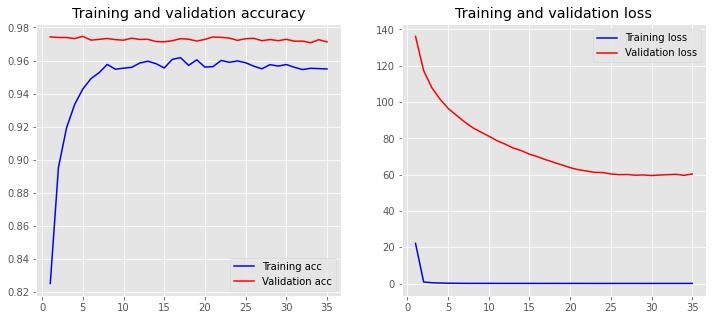

6/6 [==============================] - 4s 87ms/step
F1-score: 72.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3,0.42857142857142855,0.3529411764705882,7.0
Amount-Unit,0.9019607843137255,0.9387755102040817,0.92,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.4166666666666667,0.37037037037037035,0.39215686274509803,27.0
Characterization-Apparatus,0.6,0.2727272727272727,0.37499999999999994,11.0
Condition-Misc,0.4864864864864865,0.9,0.631578947368421,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9555555555555556,0.9885057471264368,0.9717514124293786,87.0
Material,0.6573816155988857,0.7468354430379747,0.6992592592592594,316.0
Material-Descriptor,0.5657894736842105,0.48314606741573035,0.5212121212121212,89.0
Meta,0.375,0.46153846153846156,0.41379310344827586,13.0
Nonrecipe-Mat

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3941 words (3244 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 158, 100)          718600    
                                                                 
 bidirectional_20 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 889,892
Trainable params: 889,892
Non-trainable pa

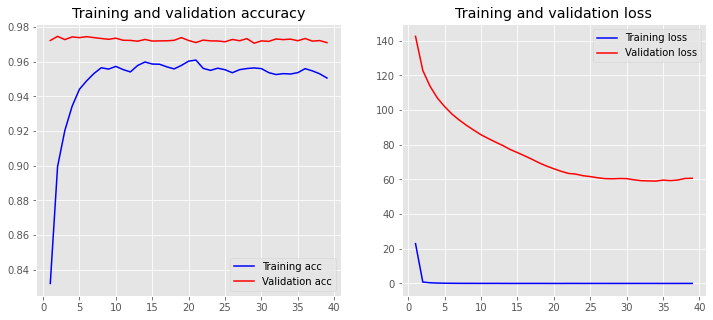

6/6 [==============================] - 4s 82ms/step
F1-score: 73.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.7142857142857143,0.588235294117647,7.0
Amount-Unit,0.8787878787878788,0.8877551020408163,0.8832487309644671,98.0
Apparatus-Descriptor,0.3333333333333333,0.4444444444444444,0.380952380952381,9.0
Apparatus-Property-Type,0.2,0.16666666666666666,0.1818181818181818,6.0
Apparatus-Unit,0.42857142857142855,0.23076923076923078,0.3,13.0
Brand,0.4090909090909091,0.3333333333333333,0.36734693877551017,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5757575757575758,0.95,0.7169811320754716,20.0
Condition-Type,0.08333333333333333,1.0,0.15384615384615385,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6918767507002801,0.7816455696202531,0.7340267459138187,316.0
Material-Descriptor,0.6075949367088608,0.5393258426966292,0.5714285714285714,89.0
Meta,0.29411764705882354,0.38461538461538464,0.3333333333

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3963 words (3254 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 158, 100)          721800    
                                                                 
 bidirectional_21 (Bidirecti  (None, 158, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 158, 43)          8643      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 158, 43)           1849      
                                                                 
Total params: 893,092
Trainable params: 893,092
Non-trainable pa

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3995 words (3260 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          725600    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 896,892
Trainable params: 896,892
Non-trainable param

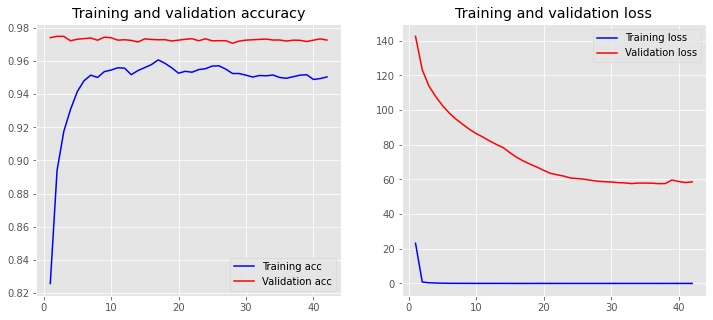

6/6 [==============================] - 3s 84ms/step
F1-score: 70.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.898989898989899,0.9081632653061225,0.9035532994923858,98.0
Apparatus-Descriptor,0.45454545454545453,0.5555555555555556,0.5,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.375,0.3333333333333333,0.35294117647058826,27.0
Characterization-Apparatus,0.5,0.18181818181818182,0.26666666666666666,11.0
Condition-Misc,0.5142857142857142,0.9,0.6545454545454545,20.0
Condition-Type,0.07692307692307693,1.0,0.14285714285714288,1.0
Condition-Unit,0.8936170212765957,0.9655172413793104,0.9281767955801106,87.0
Material,0.6791277258566978,0.689873417721519,0.6844583987441131,316.0
Material-Descriptor,0.5487804878048781,0.5056179775280899,0.5263157894736842,89.0
Meta,0.4,0.46153846153846156,0.42857142857142855,13.0
Nonrecipe-Materia

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3961 words (3260 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          722200    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 893,492
Trainable params: 893,492
Non-trainable par

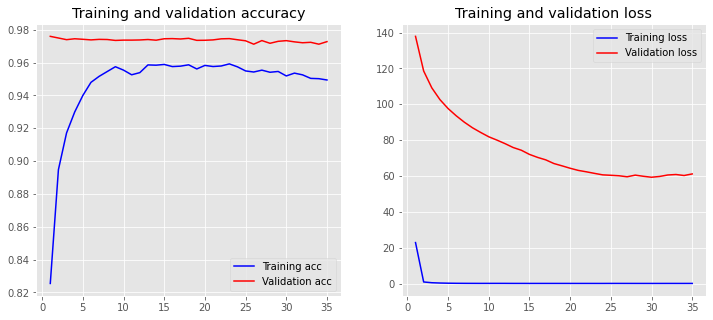

6/6 [==============================] - 3s 85ms/step
F1-score: 73.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.91,0.9285714285714286,0.9191919191919193,98.0
Apparatus-Descriptor,0.4375,0.7777777777777778,0.56,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.46153846153846156,0.5217391304347826,13.0
Brand,0.6086956521739131,0.5185185185185185,0.5599999999999999,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6428571428571429,0.9,0.75,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6588921282798834,0.7151898734177216,0.6858877086494689,316.0
Material-Descriptor,0.5164835164835165,0.5280898876404494,0.5222222222222221,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.631578947368421,0.48,0.5454545454545454,25.0
Number,0.9476190476190476,0.9386792452830188,0.94312796208

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3936 words (3266 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          720300    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 891,592
Trainable params: 891,592
Non-trainable par

In [ ]:
number_of_training_models = 4
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 3951 words (3269 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          722100    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 893,392
Trainable params: 893,392
Non-trainable param

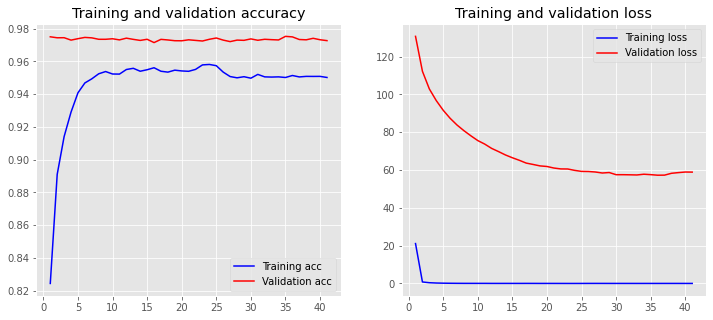

6/6 [==============================] - 3s 77ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.5714285714285714,0.4210526315789474,7.0
Amount-Unit,0.8842105263157894,0.8571428571428571,0.8704663212435233,98.0
Apparatus-Descriptor,0.5833333333333334,0.7777777777777778,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5714285714285714,0.3076923076923077,0.4,13.0
Brand,0.42857142857142855,0.3333333333333333,0.375,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9139784946236559,0.9770114942528736,0.9444444444444445,87.0
Material,0.6582633053221288,0.7436708860759493,0.6983655274888559,316.0
Material-Descriptor,0.5308641975308642,0.48314606741573035,0.5058823529411766,89.0
Meta,0.2222222222222222,0.15384615384615385,0.18181818181818185,13.0
Nonrecipe-Material,0.3333333333333333,0.28,0.3043478260869565

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6759
Points in y_train after augmentation: 6759
Converted 4001 words (3258 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          726000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 897,292
Trainable params: 897,292
Non-trainable par

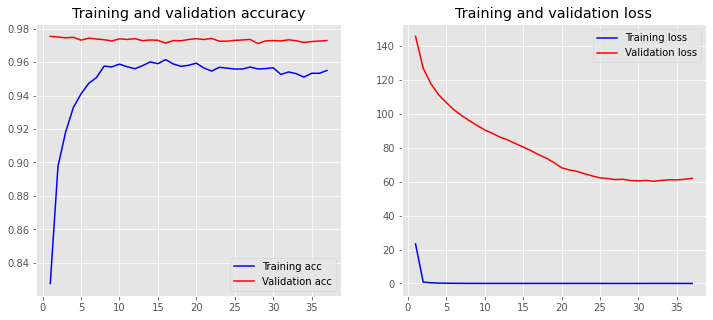

6/6 [==============================] - 3s 78ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8888888888888888,0.8979591836734694,0.8934010152284263,98.0
Apparatus-Descriptor,0.38461538461538464,0.5555555555555556,0.4545454545454546,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5714285714285714,0.3076923076923077,0.4,13.0
Brand,0.631578947368421,0.4444444444444444,0.5217391304347826,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5,0.8,0.6153846153846154,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9325842696629213,0.9540229885057471,0.9431818181818182,87.0
Material,0.6607142857142857,0.7025316455696202,0.6809815950920244,316.0
Material-Descriptor,0.5180722891566265,0.48314606741573035,0.5,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material

In [ ]:
number_of_training_models = 2
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4381 words (3356 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          773800    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 945,092
Trainable params: 945,092
Non-trainable p

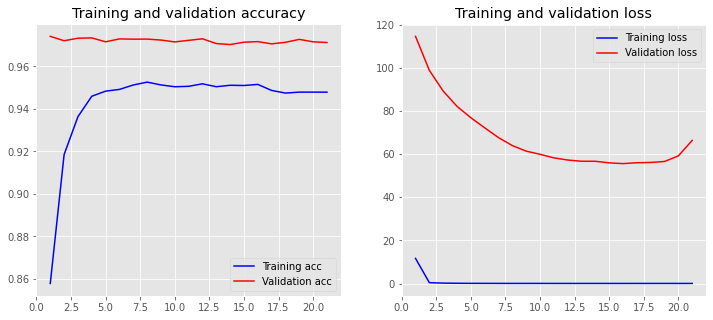

6/6 [==============================] - 3s 78ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2222222222222222,0.5714285714285714,0.32,7.0
Amount-Unit,0.90625,0.8877551020408163,0.8969072164948454,98.0
Apparatus-Descriptor,0.4166666666666667,0.5555555555555556,0.4761904761904762,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,1.0,0.15384615384615385,0.2666666666666667,13.0
Brand,0.4117647058823529,0.25925925925925924,0.3181818181818182,27.0
Characterization-Apparatus,0.6666666666666666,0.18181818181818182,0.28571428571428575,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9438202247191011,0.9655172413793104,0.9545454545454545,87.0
Material,0.7157534246575342,0.6613924050632911,0.6874999999999999,316.0
Material-Descriptor,0.4819277108433735,0.449438202247191,0.46511627906976744,89.0
Meta,0.42857142857142855,0.46153846153846156,0.4444444444444445,13.0
Nonrecipe-Mat

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4385 words (3354 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          774000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 945,292
Trainable params: 945,292
Non-trainable p

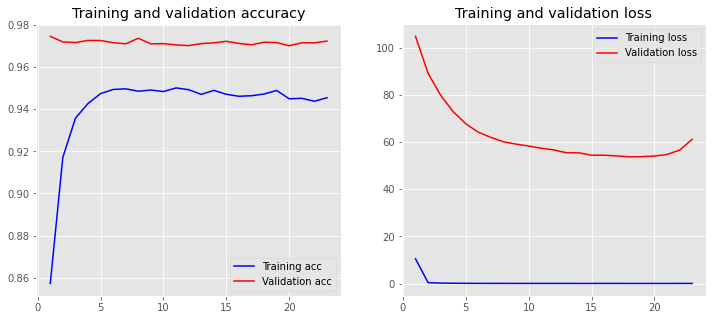

6/6 [==============================] - 3s 83ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3076923076923077,0.5714285714285714,0.4,7.0
Amount-Unit,0.8958333333333334,0.8775510204081632,0.8865979381443299,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.47619047619047616,0.37037037037037035,0.4166666666666667,27.0
Characterization-Apparatus,0.3333333333333333,0.09090909090909091,0.14285714285714288,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9120879120879121,0.9540229885057471,0.9325842696629213,87.0
Material,0.6835016835016835,0.6424050632911392,0.6623164763458401,316.0
Material-Descriptor,0.49382716049382713,0.449438202247191,0.47058823529411764,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Materi

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4375 words (3377 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          775300    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 946,592
Trainable params: 946,592
Non-trainable p

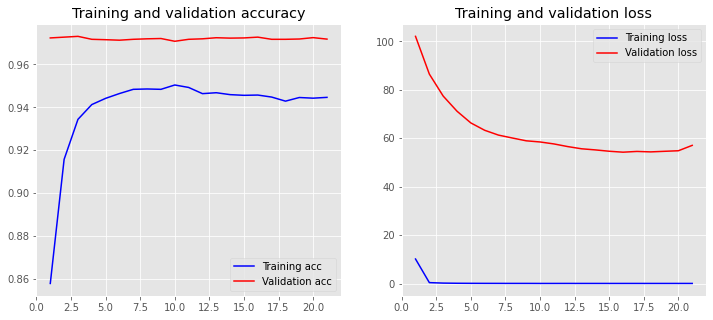

6/6 [==============================] - 3s 80ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.25,0.42857142857142855,0.3157894736842105,7.0
Amount-Unit,0.9263157894736842,0.8979591836734694,0.911917098445596,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.3076923076923077,0.380952380952381,13.0
Brand,0.4444444444444444,0.2962962962962963,0.3555555555555555,27.0
Characterization-Apparatus,0.25,0.18181818181818182,0.2105263157894737,11.0
Condition-Misc,0.6428571428571429,0.9,0.75,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9032258064516129,0.9655172413793104,0.9333333333333333,87.0
Material,0.6381766381766382,0.7088607594936709,0.6716641679160421,316.0
Material-Descriptor,0.4794520547945205,0.39325842696629215,0.43209876543209874,89.0
Meta,0.5714285714285714,0.3076923076923077,0.4,13.0
Nonrecipe-Material,0.3333333333333333,0.36,0.34615384615384615,25

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4330 words (3366 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 158, 100)          769700    
                                                                 
 bidirectional_5 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 940,992
Trainable params: 940,992
Non-trainable p

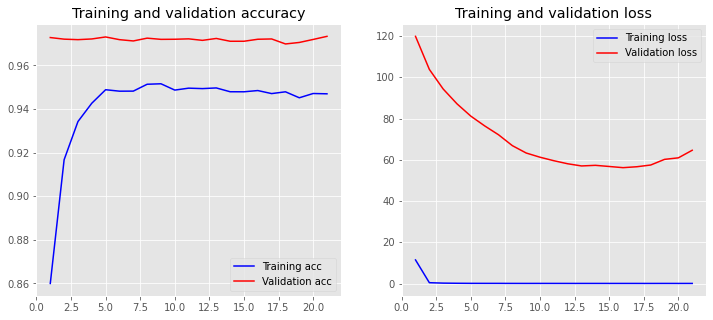

6/6 [==============================] - 3s 82ms/step
F1-score: 70.9%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.42857142857142855,0.375,7.0
Amount-Unit,0.9139784946236559,0.8673469387755102,0.8900523560209423,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.5,0.23076923076923078,0.3157894736842105,13.0
Brand,0.3888888888888889,0.25925925925925924,0.3111111111111111,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.5142857142857142,0.9,0.6545454545454545,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9195402298850575,0.9195402298850575,0.9195402298850575,87.0
Material,0.6900958466453674,0.6835443037974683,0.6868044515103339,316.0
Material-Descriptor,0.4666666666666667,0.47191011235955055,0.4692737430167598,89.0
Meta,0.46153846153846156,0.46153846153846156,0.46153846153846156,13.0
Nonrecipe-Material,0.25,0.28,0.2641509433962264,25.0
Number,0

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4338 words (3373 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 158, 100)          771200    
                                                                 
 bidirectional_6 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 942,492
Trainable params: 942,492
Non-trainable p

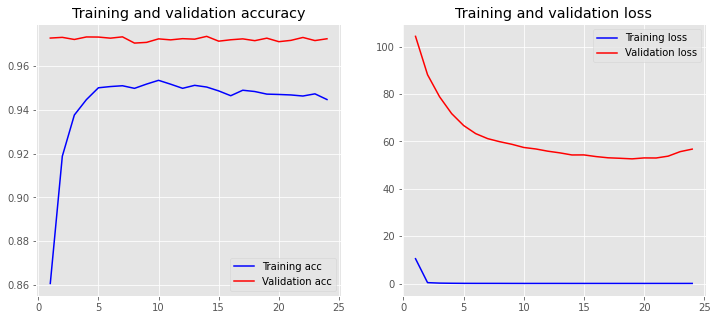

6/6 [==============================] - 3s 85ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.5,0.5714285714285714,0.5333333333333333,7.0
Amount-Unit,0.9019607843137255,0.9387755102040817,0.92,98.0
Apparatus-Descriptor,0.6666666666666666,0.6666666666666666,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8333333333333334,0.38461538461538464,0.5263157894736842,13.0
Brand,0.5,0.3333333333333333,0.4,27.0
Characterization-Apparatus,0.4,0.18181818181818182,0.25000000000000006,11.0
Condition-Misc,0.5483870967741935,0.85,0.6666666666666665,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.898876404494382,0.9195402298850575,0.9090909090909091,87.0
Material,0.6371428571428571,0.7056962025316456,0.6696696696696696,316.0
Material-Descriptor,0.4065934065934066,0.4157303370786517,0.41111111111111115,89.0
Meta,0.4,0.3076923076923077,0.34782608695652173,13.0
Nonrecipe-Material,0.2692307692307692,0.28,0.27450980392156865,2

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4354 words (3346 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 158, 100)          770100    
                                                                 
 bidirectional_7 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 941,392
Trainable params: 941,392
Non-trainable p

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4359 words (3370 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 158, 100)          773000    
                                                                 
 bidirectional (Bidirectiona  (None, 158, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 158, 43)          8643      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 158, 43)           1849      
                                                                 
Total params: 944,292
Trainable params: 944,292
Non-trainable par

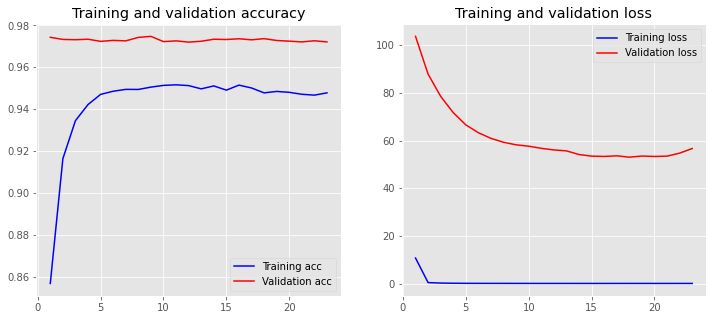

6/6 [==============================] - 4s 144ms/step
F1-score: 71.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.2,0.42857142857142855,0.27272727272727276,7.0
Amount-Unit,0.8969072164948454,0.8877551020408163,0.8923076923076922,98.0
Apparatus-Descriptor,0.5,0.6666666666666666,0.5714285714285715,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.34782608695652173,0.2962962962962963,0.31999999999999995,27.0
Characterization-Apparatus,0.5,0.09090909090909091,0.15384615384615385,11.0
Condition-Misc,0.5454545454545454,0.9,0.679245283018868,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6579710144927536,0.7183544303797469,0.6868381240544629,316.0
Material-Descriptor,0.5111111111111111,0.5168539325842697,0.5139664804469274,89.0
Meta,0.3333333333333333,0.3076923076923077,0.32,13.0
Nonrecipe-Material,0.25,0.32,0.2807017543859649,25.0
Number,0.935,0.8820754716981132,0.9077669902912621,212.0
Operati

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4353 words (3362 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 158, 100)          771600    
                                                                 
 bidirectional_1 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 942,892
Trainable params: 942,892
Non-trainable p

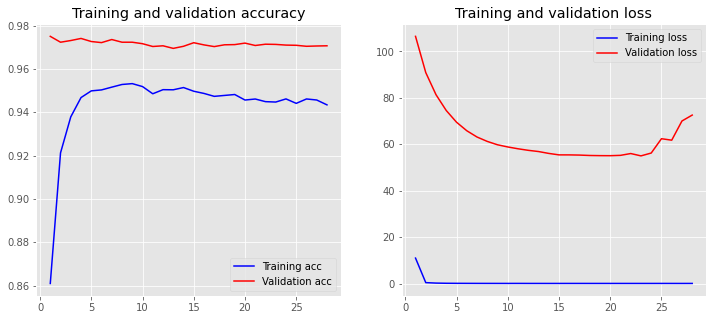

6/6 [==============================] - 5s 139ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.9340659340659341,0.8673469387755102,0.8994708994708994,98.0
Apparatus-Descriptor,0.5833333333333334,0.7777777777777778,0.6666666666666666,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.4,0.2962962962962963,0.3404255319148936,27.0
Characterization-Apparatus,0.18181818181818182,0.18181818181818182,0.18181818181818182,11.0
Condition-Misc,0.48484848484848486,0.8,0.6037735849056605,20.0
Condition-Type,0.0,0.0,0.0,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.670926517571885,0.6645569620253164,0.6677265500794913,316.0
Material-Descriptor,0.45121951219512196,0.4157303370786517,0.4327485380116959,89.0
Meta,0.29411764705882354,0.38461538461538464,0.33333333333333337,13.0
Nonrecipe-Material

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4337 words (3386 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 158, 100)          772400    
                                                                 
 bidirectional_2 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 943,692
Trainable params: 943,692
Non-trainable p

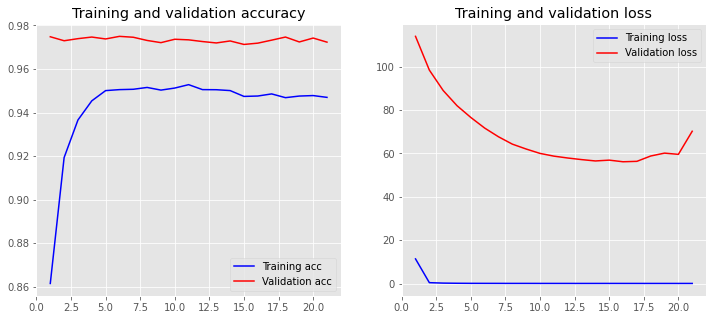

6/6 [==============================] - 4s 137ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3333333333333333,0.42857142857142855,0.375,7.0
Amount-Unit,0.8673469387755102,0.8673469387755102,0.8673469387755102,98.0
Apparatus-Descriptor,0.5454545454545454,0.6666666666666666,0.6,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.8,0.3076923076923077,0.4444444444444444,13.0
Brand,0.47058823529411764,0.2962962962962963,0.3636363636363636,27.0
Characterization-Apparatus,0.75,0.2727272727272727,0.39999999999999997,11.0
Condition-Misc,0.5625,0.9,0.6923076923076923,20.0
Condition-Type,0.09090909090909091,1.0,0.16666666666666669,1.0
Condition-Unit,0.9444444444444444,0.9770114942528736,0.96045197740113,87.0
Material,0.6907216494845361,0.6360759493670886,0.6622734761120262,316.0
Material-Descriptor,0.4657534246575342,0.38202247191011235,0.41975308641975306,89.0
Meta,0.38461538461538464,0.38461538461538464,0.38461538461538464,13.0
Nonrecipe-

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4398 words (3373 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 158, 100)          777200    
                                                                 
 bidirectional_3 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 948,492
Trainable params: 948,492
Non-trainable p

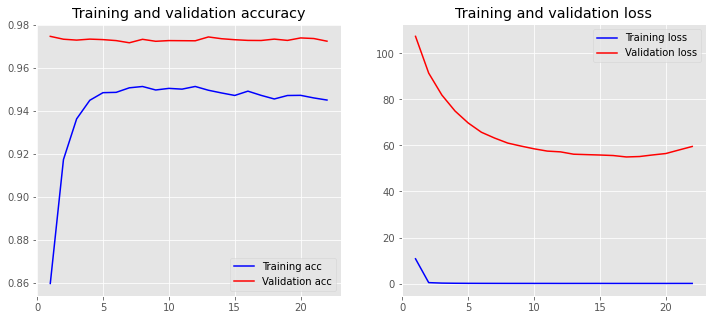

6/6 [==============================] - 7s 145ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.3,0.42857142857142855,0.3529411764705882,7.0
Amount-Unit,0.8673469387755102,0.8673469387755102,0.8673469387755102,98.0
Apparatus-Descriptor,0.46153846153846156,0.6666666666666666,0.5454545454545455,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.7142857142857143,0.38461538461538464,0.5,13.0
Brand,0.47058823529411764,0.2962962962962963,0.3636363636363636,27.0
Characterization-Apparatus,0.0,0.0,0.0,11.0
Condition-Misc,0.6071428571428571,0.85,0.7083333333333333,20.0
Condition-Type,0.125,1.0,0.2222222222222222,1.0
Condition-Unit,0.9333333333333333,0.9655172413793104,0.9491525423728815,87.0
Material,0.6507462686567164,0.689873417721519,0.6697388632872504,316.0
Material-Descriptor,0.49295774647887325,0.39325842696629215,0.43749999999999994,89.0
Meta,0.2727272727272727,0.23076923076923078,0.24999999999999994,13.0
Nonrecipe-Material,0.4137931

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 13518
Points in y_train after augmentation: 13518
Converted 4334 words (3370 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 158, 100)          770500    
                                                                 
 bidirectional_4 (Bidirectio  (None, 158, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 158, 43)          8643      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 158, 43)           1849      
                                                                 
Total params: 941,792
Trainable params: 941,792
Non-trainable p

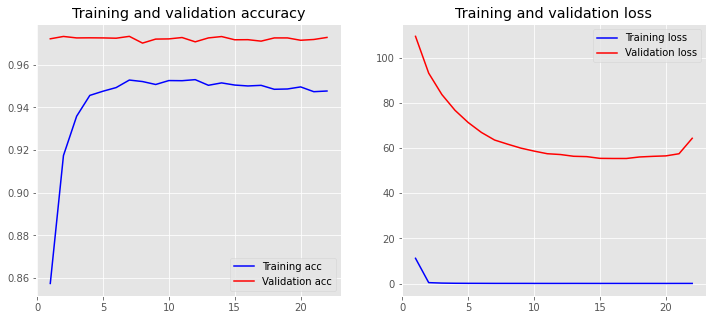

6/6 [==============================] - 4s 135ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Amount-Misc,0.4,0.5714285714285714,0.47058823529411764,7.0
Amount-Unit,0.8811881188118812,0.9081632653061225,0.8944723618090452,98.0
Apparatus-Descriptor,0.7,0.7777777777777778,0.7368421052631577,9.0
Apparatus-Property-Type,0.0,0.0,0.0,6.0
Apparatus-Unit,0.6,0.23076923076923078,0.33333333333333337,13.0
Brand,0.391304347826087,0.3333333333333333,0.36,27.0
Characterization-Apparatus,0.25,0.09090909090909091,0.13333333333333333,11.0
Condition-Misc,0.59375,0.95,0.7307692307692308,20.0
Condition-Type,0.1,1.0,0.18181818181818182,1.0
Condition-Unit,0.9130434782608695,0.9655172413793104,0.9385474860335196,87.0
Material,0.6330532212885154,0.7151898734177216,0.6716196136701338,316.0
Material-Descriptor,0.4411764705882353,0.5056179775280899,0.4712041884816754,89.0
Meta,0.2777777777777778,0.38461538461538464,0.3225806451612903,13.0
Nonrecipe-Material,0.18518518518518517,0.

In [ ]:
number_of_training_models = 5
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)